In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

from scipy.optimize import minimize 
from sklearn.metrics import mean_squared_error
from scipy.special import softmax


In [16]:
import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers
from keras import backend as K

## MNIST Dataset

In [3]:
dataset = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')

training_images = dataset[0][0]
training_labels = dataset[0][1]
testing_images = dataset[1][0]
testing_labels = dataset[1][1]

shape of training imgs: (60000, 28, 28)
shape of testing imgs: (10000, 28, 28)
shape of training labels: (60000,)
shape of testing labels: (10000,)


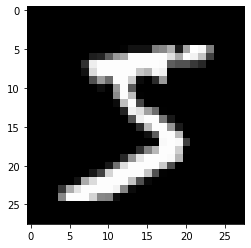

In [31]:
#show data

plt.imshow(training_images[0], cmap = 'gray')
training_labels[0]

print('shape of training imgs:', np.shape(training_images))
print('shape of testing imgs:', np.shape(testing_images))
print('shape of training labels:', np.shape(training_labels))
print('shape of testing labels:', np.shape(testing_labels))

In [137]:
# normalize and combine dataset 

X_train = training_images.reshape(training_images.shape[0], 28, 28, 1) / 255
Y_train = training_labels
X_test = testing_images.reshape(testing_images.shape[0], 28, 28, 1) / 255
Y_test = testing_labels

all_digits = np.concatenate([X_train, X_test])

## GAN

In [185]:
# discriminator architecture

input_shape = (28, 28, 1)

discriminator = keras.Sequential()
discriminator.add(keras.Input(shape = input_shape))

discriminator.add(layers.Conv2D(64, (3,3), strides = 2, padding = 'same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha = 0.2))

discriminator.add(layers.Conv2D(128, (3,3), strides = 2, padding = 'same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha = 0.2))

discriminator.add(layers.GlobalAveragePooling2D())
discriminator.add(layers.Dense(1))

discriminator.summary()

# generator architecture

latent_dim = 100
generator = keras.Sequential()
generator.add(keras.Input(shape = (latent_dim,)))
generator.add(layers.Dense(7*7*128, activation = 'relu'))
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.Dropout(0.1))

generator.add(layers.Conv2DTranspose(128, (4,4), strides = 2, padding = 'same', activation = 'relu'))
generator.add(layers.BatchNormalization())
generator.add(layers.Dropout(0.1))

generator.add(layers.Conv2DTranspose(128, (4,4), strides = 2, padding = 'same', activation = 'relu'))
generator.add(layers.BatchNormalization())
generator.add(layers.Dropout(0.1))

generator.add(layers.Conv2D(1, (7, 7), padding="same", activation= 'sigmoid'))

generator.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 batch_normalization_114 (Ba  (None, 14, 14, 64)       256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_115 (Ba  (None, 7, 7, 128)        512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 7, 7, 128)       

In [186]:
# basic GAN architecture and training logic

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator 
        self.generator = generator
        self.latent_dim = latent_dim 
        self.d_loss_tracker = keras.metrics.Mean(name = 'd_loss')
        self.g_loss_tracker = keras.metrics.Mean(name = 'g_loss')

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn 

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        batch_size = tf.shape(real_images)[0]
        # sample vectors from latent space
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
        
        # decode latent vector samples to 'fake' images
        generated_images = self.generator(random_latent_vectors)
        
        # concatenate with real images
        combined_images = tf.concat([generated_images, real_images], axis = 0)

        # implement labels, fake = 1, real = 0
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0)

        # add noise to labels, helps stablize GAN during training, prevents mode collapse and overfitting
        labels += 0.1 * tf.random.uniform(tf.shape(labels))

        # TRAIN THE DISCRIMINATOR

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # TRAIN THE GENERATOR 

        # new sample vectors from latent space
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))

        # create misleading labels, we want the discriminator to classify the generator as real = 0
        misleading_labels = tf.zeros((batch_size, 1))

        # gradients 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update state of trackers
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            'd_loss': self.d_loss_tracker.result(),
            'g_loss': self.g_loss_tracker.result()
        }


In [187]:
# initialize gan and compile

gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [195]:
epochs = 5
batch_size = 128

gan.fit(dataset, epochs = epochs, batch_size = batch_size)

Epoch 1/5
2188/2188 [==============================] - 915s 418ms/step - d_loss: 0.6823 - g_loss: 0.8196
Epoch 2/5
2188/2188 [==============================] - 765s 350ms/step - d_loss: 0.6862 - g_loss: 0.8071
Epoch 3/5
2188/2188 [==============================] - 764s 349ms/step - d_loss: 0.6744 - g_loss: 0.8279
Epoch 4/5
2188/2188 [==============================] - 772s 353ms/step - d_loss: 0.6738 - g_loss: 0.8307
Epoch 5/5
2188/2188 [==============================] - 755s 345ms/step - d_loss: 0.6845 - g_loss: 0.8183


In [159]:
"""save weights"""
#gan.save_weights('/Users/andrewgoh/Desktop/ML_Projects/gan_weights', overwrite=True, save_format=None, options=None)

In [166]:
"""load weights"""
#gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
'''gan.load_weights('/Users/andrewgoh/Desktop/ML_Projects/gan_weights', by_name=False, skip_mismatch=False, options=None)

# set optimizer and compile 
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
'''

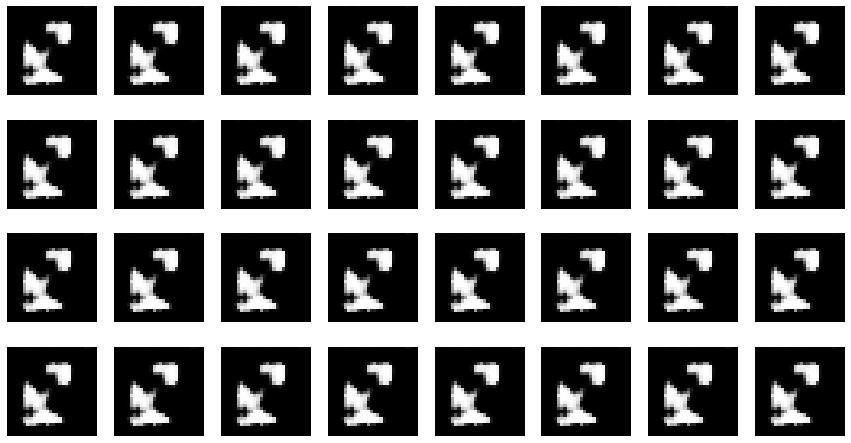

In [199]:
# generate random digits

scale = 0.1
length = 0

plt.figure(figsize=(15,8))
for i in range(32): 
  z = []
  for j in range(latent_dim):
    z.append(np.random.normal(loc = np.random.uniform(-length, length), scale = scale))

  ax = plt.subplot(4, 8, i + 1)
  z_vector_sampled = np.array([z])
  generated = generator.predict(z_vector_sampled, verbose = False)
  image = generated[0].reshape(28,28)
  plt.imshow(image, cmap = 'gray')
  plt.axis("off")
